In [2]:
#!pip install EIA-python
import numpy as np 
import pandas as pd
import json
import eia
from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import networkx as nx
import matplotlib.pyplot as plt

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [3]:
apiKey = "5f54b3e66477e22ec068066b1de8026d"
api = eia.API(apiKey)

In [4]:
url = "http://api.eia.gov/geoset/?geoset_id=sssssss&regions=region1,region2,region3,...&api_key={0}[&start=|&num=][&end=][&out=xml|json]".format(api)

In [5]:
series_id_list = ["INTL.57-1-DZA-TBPD.M", "INTL.57-1-AGO-TBPD.M", "INTL.57-1-COG-TBPD.M", "INTL.57-1-COD-TBPD.M", 
                  "INTL.57-1-ECU-TBPD.M","INTL.57-1-GNQ-TBPD.M","INTL.57-1-GAB-TBPD.M","INTL.57-1-IRN-TBPD.M",
                  "INTL.57-1-IRQ-TBPD.M", "INTL.57-1-KWT-TBPD.M", "INTL.57-1-LBY-TBPD.M", "INTL.57-1-NGA-TBPD.M",
                  "INTL.57-1-QAT-TBPD.M", "INTL.57-1-RUS-TBPD.M", "INTL.57-1-SAU-TBPD.M","INTL.57-1-ARE-TBPD.M",
                  "INTL.57-1-VEN-TBPD.M", "INTL.57-1-USA-TBPD.M"]

In [6]:
df_list = [pd.DataFrame(api.data_by_series(series)) for series in series_id_list]

In [7]:
oil_data = pd.concat(df_list, axis=1)

In [8]:
oil_data = oil_data.replace("--", np.nan)

In [9]:
oil_data.dropna().shape

(331, 18)

In [10]:
oil_data.shape

(571, 18)

In [11]:
oil_data_reduced = oil_data.dropna()

In [12]:
oil_data_reduced

,"Crude oil including lease condensate production, Algeria, Monthly (thousand barrels per day)","Crude oil including lease condensate production, Angola, Monthly (thousand barrels per day)","Crude oil including lease condensate production, Congo-Brazzaville, Monthly (thousand barrels per day)","Crude oil including lease condensate production, Congo-Kinshasa, Monthly (thousand barrels per day)","Crude oil including lease condensate production, Ecuador, Monthly (thousand barrels per day)","Crude oil including lease condensate production, Equatorial Guinea, Monthly (thousand barrels per day)","Crude oil including lease condensate production, Gabon, Monthly (thousand barrels per day)","Crude oil including lease condensate production, Iran, Monthly (thousand barrels per day)","Crude oil including lease condensate production, Iraq, Monthly (thousand barrels per day)","Crude oil including lease condensate production, Kuwait, Monthly (thousand barrels per day)","Crude oil including lease condensate production, Libya, Monthly (thousand barrels per day)","Crude oil including lease condensate production, Nigeria, Monthly (thousand barrels per day)","Crude oil including lease condensate production, Qatar, Monthly (thousand barrels per day)","Crude oil including lease condensate production, Russia, Monthly (thousand barrels per day)","Crude oil including lease condensate production, Saudi Arabia, Monthly (thousand barrels per day)","Crude oil including lease condensate production, United Arab Emirates, Monthly (thousand barrels per day)","Crude oil including lease condensate production, Venezuela, Monthly (thousand barrels per day)","Crude oil including lease condensate production, United States, Monthly (thousand barrels per day)"
1993 01,1195.0,484.857,181.0,25.0,328.0,4.5,319.0,3539.997,500.0,1657.102,1462.806,2032.0,449.688,7194.074,8500.0,2211.030,2484.343,6961.007
1993 02,1195.0,505.273,181.0,25.0,328.0,4.5,319.0,3636.983,500.0,1845.072,1408.445,2013.0,429.701,7180.238,8440.0,2220.664,2463.726,6942.592
1993 03,1175.0,510.376,181.0,25.0,328.0,4.5,319.0,3588.490,500.0,1632.369,1334.316,1984.0,399.722,7088.008,8300.0,2186.945,2412.183,6974.128
1993 04,1175.0,544.061,181.0,25.0,328.0,4.5,319.0,3394.518,500.0,1627.422,1334.316,1936.0,399.722,7069.563,8000.0,2186.945,2412.183,6881.308
1993 05,1175.0,544.061,181.0,25.0,343.0,4.5,319.0,3539.997,500.0,1694.201,1334.316,1936.0,419.708,6912.766,8000.0,2148.408,2412.183,6846.920
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020 03,1260.0,1372.000,282.0,23.0,541.0,163.0,200.0,2778.000,4537.0,3081.000,150.000,1939.0,1530.000,10894.000,9852.0,3814.000,670.000,12737.065
2020 04,1260.0,1342.000,293.0,23.0,210.0,168.0,190.0,2695.000,4537.0,3330.000,135.000,1889.0,1530.000,10935.000,11653.0,4128.000,620.000,12009.967
2020 05,1060.0,1272.000,283.0,23.0,335.0,133.0,180.0,2676.000,4257.0,2378.000,130.000,1809.0,1530.000,8993.000,8603.0,2825.000,545.000,10018.774
2020 06,1025.0,1242.000,303.0,23.0,515.0,148.0,180.0,2615.000,3786.0,2269.000,130.000,1659.0,1530.000,8925.000,7754.0,2675.000,400.000,10446.367


In [13]:
oil_data_reduced.columns = ["Algeria", "Angola", "Congo-Brazzaville", "Congo-Kinshasa", "Ecuador", "Equatorial Guinea", "Gabon", "Iran",
                "Iraq", "Kuwait", "Libya", "Nigeria", "Qatar", "Russia", "Saudi Arabia", "United Arab Emirates", "Venezuela", "USA"]
corrs = oil_data_reduced.corr()

In [14]:
corrs[(corrs>=.5) | (corrs<=-.5) & (corrs!=1)]

,Algeria,Angola,Congo-Brazzaville,Congo-Kinshasa,Ecuador,Equatorial Guinea,Gabon,Iran,Iraq,Kuwait,Libya,Nigeria,Qatar,Russia,Saudi Arabia,United Arab Emirates,Venezuela,USA
Algeria,1.000000,0.630587,NaN,-0.655868,0.596937,0.897254,NaN,NaN,NaN,NaN,NaN,0.699516,NaN,0.522743,NaN,NaN,NaN,NaN
Angola,0.630587,1.000000,NaN,-0.715705,0.811296,0.735478,-0.764797,NaN,0.633256,0.794321,NaN,NaN,0.911548,0.891475,0.675096,0.735898,NaN,NaN
Congo-Brazzaville,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Congo-Kinshasa,-0.655868,-0.715705,NaN,1.000000,-0.675867,-0.792636,0.757919,NaN,NaN,-0.562470,NaN,NaN,-0.690667,-0.730301,-0.522284,NaN,NaN,NaN
Ecuador,0.596937,0.811296,NaN,-0.675867,1.000000,0.739408,-0.758616,NaN,0.632873,0.830484,NaN,NaN,0.803624,0.862396,0.724380,0.723725,NaN,NaN
Equatorial Guinea,0.897254,0.735478,NaN,-0.792636,0.739408,1.000000,-0.670299,NaN,NaN,0.521950,NaN,0.641835,0.609934,0.684592,NaN,NaN,NaN,NaN
Gabon,NaN,-0.764797,NaN,0.757919,-0.758616,-0.670299,1.000000,NaN,-0.749143,-0.777018,NaN,NaN,-0.851624,-0.926435,-0.688536,-0.750173,0.659365,NaN
Iran,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Iraq,NaN,0.633256,NaN,NaN,0.632873,NaN,-0.749143,NaN,1.000000,0.770972,-0.538854,NaN,0.815452,0.759971,0.703544,0.835473,-0.607744,0.698585
Kuwait,NaN,0.794321,NaN,-0.562470,0.830484,0.521950,-0.777018,NaN,0.770972,1.000000,NaN,NaN,0.867255,0.900999,0.915427,0.950333,-0.588070,0.590601


In [15]:
# Transform it in a links data frame (3 columns only):
links = corrs.stack().reset_index()
links

,level_0,level_1,0
0,Algeria,Algeria,1.000000
1,Algeria,Angola,0.630587
2,Algeria,Congo-Brazzaville,0.027057
3,Algeria,Congo-Kinshasa,-0.655868
4,Algeria,Ecuador,0.596937
...,...,...,...
319,USA,Russia,0.473852
320,USA,Saudi Arabia,0.574323
321,USA,United Arab Emirates,0.732036
322,USA,Venezuela,-0.715465


In [16]:
links.columns = ['var1', 'var2','value']
links['var1'].value_counts()
len(links['var1'].unique())

18

In [17]:
# Keep only correlation over a threshold and remove self correlation (cor(A,A)=1)
links_filtered=links.loc[ (links['value'] > 0.5) & (links['var1'] != links['var2']) ]

In [18]:
links_filtered['var1'].value_counts()

Russia                  9
Kuwait                  9
Angola                  9
Ecuador                 9
Qatar                   8
Saudi Arabia            8
Iraq                    8
United Arab Emirates    8
Equatorial Guinea       7
Algeria                 5
USA                     4
Gabon                   2
Nigeria                 2
Congo-Kinshasa          1
Venezuela               1
Name: var1, dtype: int64

In [19]:
links_filtered_USA = links_filtered[links_filtered['var1']=='USA']
links_filtered_Ven = links_filtered[links_filtered['var1']=='Venezuela']
links_filtered_Algeria = links_filtered[links_filtered['var1']=='Algeria']
links_filtered_Iran = links_filtered[links_filtered['var1']=='Iran']
links_filtered_Russia = links_filtered[links_filtered['var1']=='Russia']
links_filtered_Saudi = links_filtered[links_filtered['var1']=='Saudi']


In [20]:
# Build your graph
USA=nx.from_pandas_edgelist(links_filtered_USA, 'var1', 'var2')
Venezuela=nx.from_pandas_edgelist(links_filtered_Ven, 'var1', 'var2')
Algeria = nx.from_pandas_edgelist(links_filtered_Algeria, 'var1', 'var2')
Iran = nx.from_pandas_edgelist(links_filtered_Iran, 'var1', 'var2')
Russia = nx.from_pandas_edgelist(links_filtered_Russia, 'var1', 'var2')
Saudi = nx.from_pandas_edgelist(links_filtered_Saudi, 'var1', 'var2')

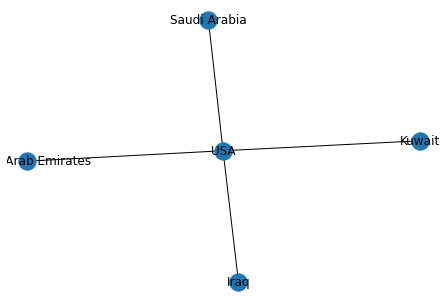

In [21]:
# Plot the network
nx.draw(USA,with_labels=True, edge_color='black', linewidths=1, font_size=12)

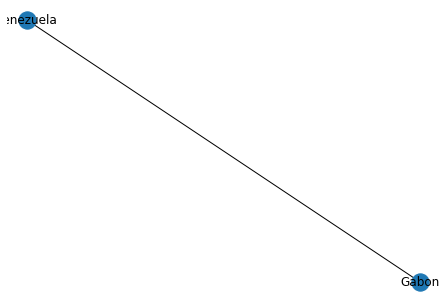

In [22]:
nx.draw(Venezuela, with_labels=True, edge_color='black', linewidths=1, font_size=12)

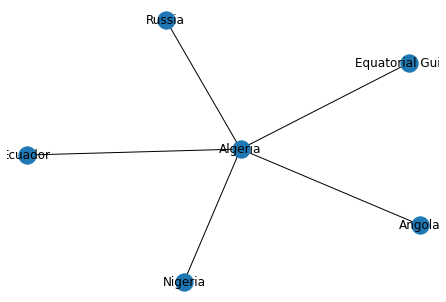

In [23]:
nx.draw(Algeria, with_labels=True, edge_color='black', linewidths=1, font_size=12)

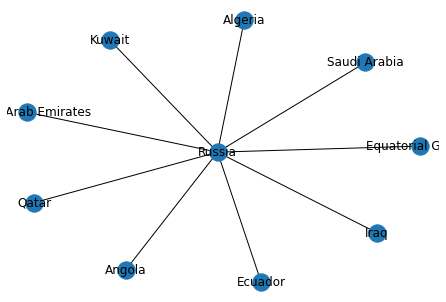

In [25]:
nx.draw(Russia, with_labels=True, edge_color='black', linewidths=1, font_size=12)

In [27]:
links_filtered=links.loc[ (links['value'] < -0.5) & (links['var1'] != links['var2']) ]

In [28]:
links_filtered_USA = links_filtered[links_filtered['var1']=='USA']
links_filtered_Ven = links_filtered[links_filtered['var1']=='Venezuela']
links_filtered_Algeria = links_filtered[links_filtered['var1']=='Algeria']
links_filtered_Iran = links_filtered[links_filtered['var1']=='Iran']
links_filtered_Russia = links_filtered[links_filtered['var1']=='Russia']
links_filtered_Saudi = links_filtered[links_filtered['var1']=='Saudi']

In [29]:
# Build your graph
USA=nx.from_pandas_edgelist(links_filtered_USA, 'var1', 'var2')
Venezuela=nx.from_pandas_edgelist(links_filtered_Ven, 'var1', 'var2')
Algeria = nx.from_pandas_edgelist(links_filtered_Algeria, 'var1', 'var2')
Iran = nx.from_pandas_edgelist(links_filtered_Iran, 'var1', 'var2')
Russia = nx.from_pandas_edgelist(links_filtered_Russia, 'var1', 'var2')
Saudi = nx.from_pandas_edgelist(links_filtered_Saudi, 'var1', 'var2')

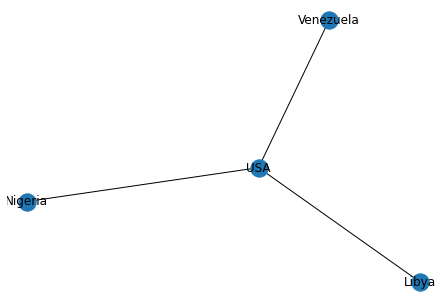

In [32]:
nx.draw(USA,with_labels=True, edge_color='black', linewidths=1, font_size=12)

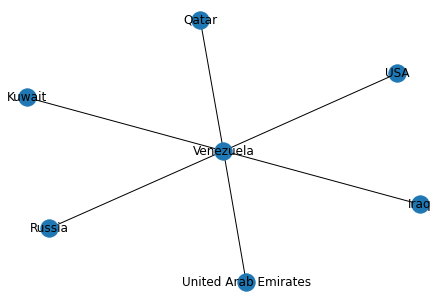

In [33]:
nx.draw(Venezuela,with_labels=True, edge_color='black', linewidths=1, font_size=12)

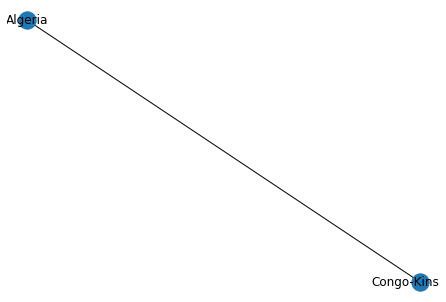

In [34]:
nx.draw(Algeria,with_labels=True, edge_color='black', linewidths=1, font_size=12)

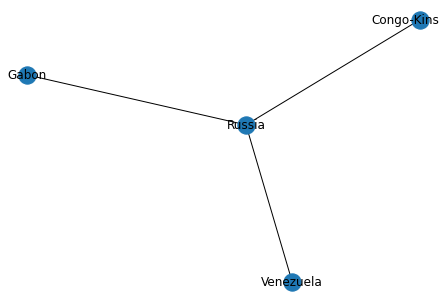

In [36]:
nx.draw(Russia,with_labels=True, edge_color='black', linewidths=1, font_size=12)